In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


In [ ]:
"""
Part One, Camera Calibration & Undistortion
"""

In [15]:
def display(img, title):
    plt.imshow(img)
    plt.title(title)
    plt.show()

In [10]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

image_shape = cv2.imread(images[0]).shape

# Step through the list and search for chessboard corners

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points    
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_shape[::-1][1:3], None, None)

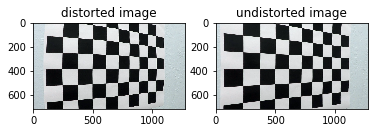

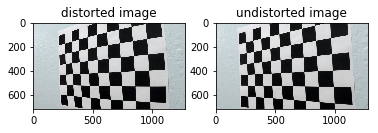

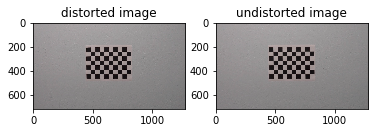

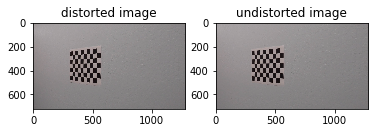

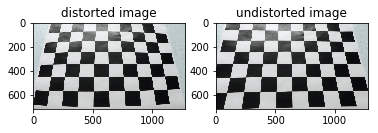

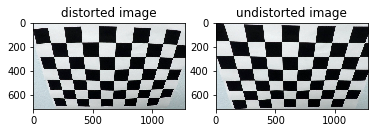

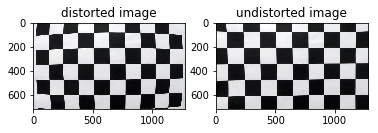

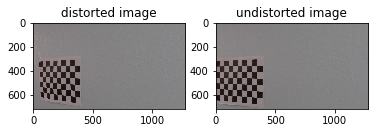

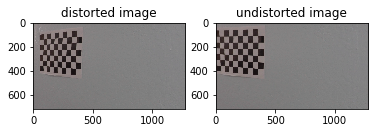

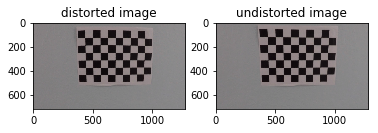

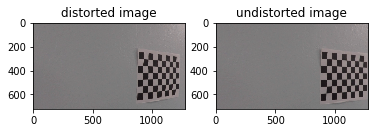

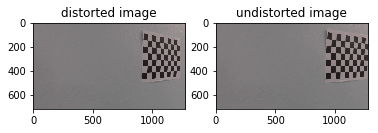

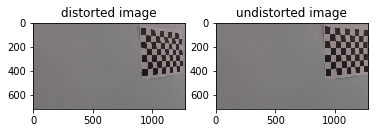

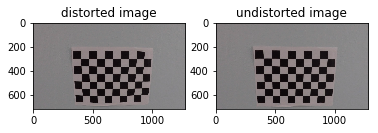

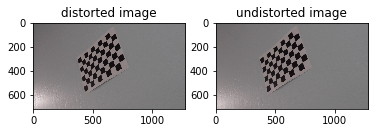

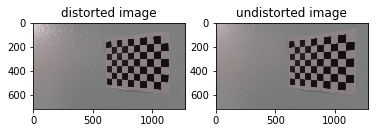

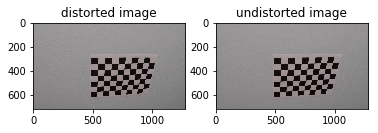

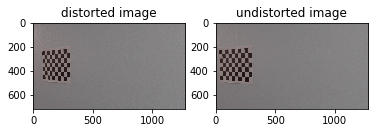

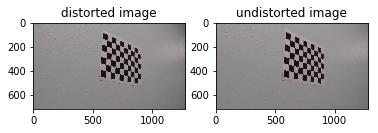

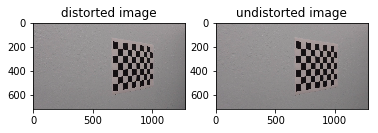

In [11]:
for fname in images:
    img = cv2.imread(fname)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    f,ax = plt.subplots(1,2)
    ax[0].imshow(img)
    ax[0].set_title('distorted image')
    ax[1].imshow(dst)
    ax[1].set_title('undistorted image')
    plt.show()

plt.close()

In [ ]:
"""
Part Two: Color Space & Gradient
"""

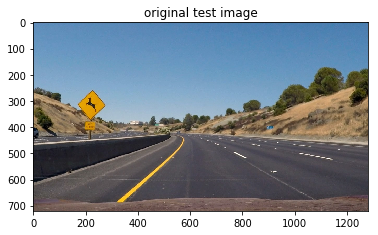

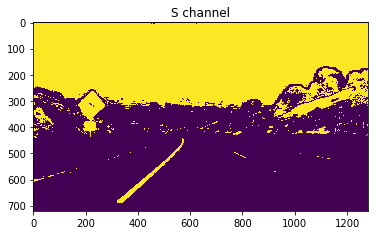

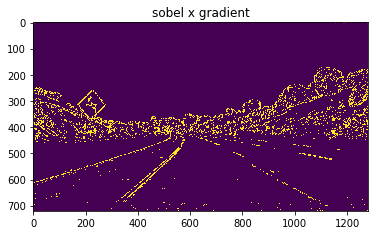

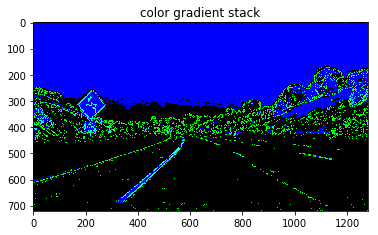

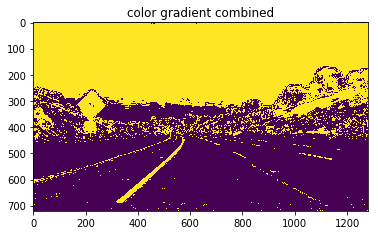

In [16]:
S_CHANNEL_THRESH = (90, 255)

def get_S_channel_binary_mask(image):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    LOWER_B, UPPER_B = S_CHANNEL_THRESH
    S = hls[:,:,2]
    binary = np.zeros_like(S)
    binary[(S >= LOWER_B) & (S <= UPPER_B)] = 1
    return binary

GRADIENT_THRESH = (20, 100)

def get_gradient_binary_mask(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    LOWER_B, UPPER_B = GRADIENT_THRESH
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))
    sobel_x_binary = np.zeros_like(scaled_sobel)
    sobel_x_binary[(scaled_sobel >= LOWER_B) & (scaled_sobel <= UPPER_B)] = 1
    return sobel_x_binary

def get_color_gradient_stack_binary_mask(image):
    s_binary = get_S_channel_binary_mask(image)
    sx_binary = get_gradient_binary_mask(image)
    return np.dstack((np.zeros_like(s_binary), sx_binary, s_binary)) * 255

def get_color_gradient_combined_binary_mask(image):
    s_binary = get_S_channel_binary_mask(image)
    sx_binary = get_gradient_binary_mask(image)
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(s_binary == 1) | (sx_binary == 1)] = 1
    return combined_binary * 255
    
    
# Manual test the result of using S channel only.
test_img = mpimg.imread('test_images/test2.jpg')
s_binary = get_S_channel_binary_mask(test_img)
sx_binary = get_gradient_binary_mask(test_img)
stack_binary = get_color_gradient_stack_binary_mask(test_img)
combined_binary = get_color_gradient_combined_binary_mask(test_img)

display(test_img, 'original test image')
display(s_binary, 'S channel')
display(sx_binary, 'sobel x gradient')
display(stack_binary, 'color gradient stack')
display(combined_binary, 'color gradient combined')

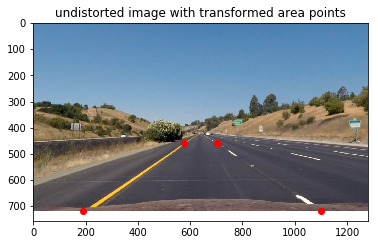

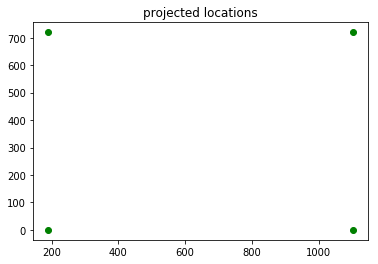

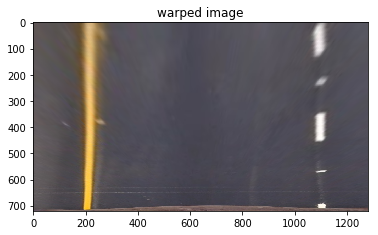

In [51]:
"""
Part Three: Perspective Transform
I will be using "test_images/straight_lines1.jpg" as an example.
"""
SRC_A, SRC_B, SRC_C, SRC_D = (190, 720), (1102, 720), (578, 460), (702, 460)
DST_A, DST_B, DST_C, DST_D = (190, 720), (1102, 720), (190, 0), (1102, 0)

straight_img = mpimg.imread('test_images/straight_lines1.jpg')
undistorted_straight_img = cv2.undistort(straight_img, mtx, dist, None, mtx)


plt.imshow(undistorted_straight_img)
plt.imsave('output_images/undistorted_straight_lines1.jpg', undistorted_straight_img)


plt.plot(SRC_A[0], SRC_A[1], 'ro')
plt.plot(SRC_B[0], SRC_B[1], 'ro')
plt.plot(SRC_C[0], SRC_C[1], 'ro')
plt.plot(SRC_D[0], SRC_D[1], 'ro')
plt.title('undistorted image with transformed area points')
plt.show()

# Plot warped locations.
plt.plot(DST_A[0], DST_A[1], 'go')
plt.plot(DST_B[0], DST_B[1], 'go')
plt.plot(DST_C[0], DST_C[1], 'go')
plt.plot(DST_D[0], DST_D[1], 'go')
plt.title('projected locations')
plt.show()

SRC_PTS = np.float32([SRC_A, SRC_B, SRC_C, SRC_D])
DST_PTS = np.float32([DST_A, DST_B, DST_C, DST_D])

M = cv2.getPerspectiveTransform(SRC_PTS, DST_PTS)
M_reverse = cv2.getPerspectiveTransform(DST_PTS, SRC_PTS)

w, h, _ = undistorted_straight_img.shape
warped = cv2.warpPerspective(undistorted_straight_img, M, (h, w), flags=cv2.INTER_LINEAR)
display(warped, 'warped image')

plt.show()